In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
# from tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


In [48]:
# load data
company = '005930'

start = dt.datetime(2012,1,1)
end = dt.datetime(2022,1,1)

data = web.DataReader(company, 'naver', start, end)

data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-02,21400,21600,21300,21600,263300
2012-01-03,21860,22100,21840,22100,339046
2012-01-04,22100,22200,21500,21600,342389
2012-01-05,21460,21580,21100,21100,346691
2012-01-06,21120,21319,20600,20800,376753


In [49]:
# prepare data
scaler = MinMaxScaler(feature_range=(0,1)) # transform the data range from (0-1000) to (0-1)
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1)) # only interest the closing price # reshape to (-1, 1) represent (row, column) - column as 1 but row unknown

prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0]) # x = [[12345, 678910]], x[0, 1] = 678910
    y_train.append(scaled_data[x, 0])
    pass

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [50]:
# Build the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #  prediction of the next closing price

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)


Epoch 1/25
76/76 [==============================] - 19s 65ms/step - loss: 0.0068
Epoch 2/25
76/76 [==============================] - 5s 66ms/step - loss: 0.0026
Epoch 3/25
76/76 [==============================] - 5s 67ms/step - loss: 0.0020
Epoch 4/25
76/76 [==============================] - 5s 66ms/step - loss: 0.0022
Epoch 5/25
76/76 [==============================] - 5s 66ms/step - loss: 0.0021
Epoch 6/25
76/76 [==============================] - 5s 68ms/step - loss: 0.0019
Epoch 7/25
76/76 [==============================] - 5s 66ms/step - loss: 0.0017
Epoch 8/25
76/76 [==============================] - 5s 66ms/step - loss: 0.0017
Epoch 9/25
76/76 [==============================] - 5s 71ms/step - loss: 0.0014
Epoch 10/25
76/76 [==============================] - 6s 79ms/step - loss: 0.0019
Epoch 11/25
76/76 [==============================] - 6s 78ms/step - loss: 0.0015
Epoch 12/25
76/76 [==============================] - 6s 76ms/step - loss: 0.0016
Epoch 13/25
76/76 [=================

In [51]:
''' Test the model accuracy on Existing data '''

# Load the data
test_start = dt.datetime(2022,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(company, 'naver', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

In [52]:
# Make predictions on test data
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    pass

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

8/8 [==============================] - 4s 18ms/step


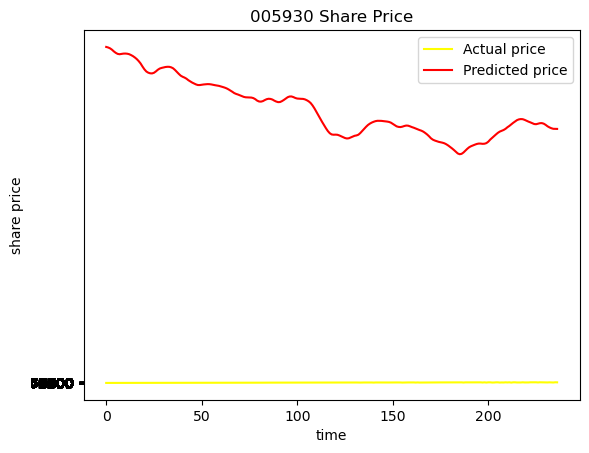

['78600' '78700' '77400' '76900' '78300' '78000' '78900' '78900' '77900'
 '77300' '77500' '77000' '76300' '76500' '75600' '75100' '74000' '73300'
 '71300' '73300' '73300' '74000' '73000' '73500' '74700' '75400' '74900'
 '73700' '73700' '74800' '75000' '74300' '74200' '73400' '73000' '71500'
 '71900' '72100' '71700' '72900' '71500' '70100' '69500' '71200' '70000'
 '70200' '69500' '70400' '71200' '70700' '69900' '70300' '70500' '69800'
 '69800' '69700' '70200' '69900' '69600' '69100' '69300' '69200' '68500'
 '68000' '67800' '67900' '67000' '68700' '67500' '66600' '66700' '67300'
 '67400' '67700' '67000' '66300' '66100' '65000' '64800' '67400' '67300'
 '67500' '67900' '66500' '66100' '65700' '65700' '64900' '66500' '66300'
 '67600' '68100' '67500' '68000' '67900' '66500' '66400' '65900' '66500'
 '67700' '67400' '66700' '66800' '65500' '65300' '65200' '63800' '62100'
 '61900' '60700' '60900' '59800' '58700' '58500' '57600' '57400' '58400'
 '58800' '59400' '58000' '57000' '56200' '57100' '5

In [57]:
# Plot the test predictions
plt.plot(actual_prices, color='yellow', label=f'Actual price')
plt.plot(predicted_prices, color='red', label=f'Predicted price')
plt.title(f'{company} Share Price')
plt.xlabel('time')
plt.ylabel('share price')
plt.legend()
plt.show()

print(actual_prices)